# Introduction to Diffusion Model

본 실습 자료에서는 diffusion model을 정의하고 학습하는 과정을 직접 진행해 볼 예정입니다.

`diffusers`라는 Python 모듈을 활용하여 diffusion model에 필요한 요소들을 정의하고 학습하는 루틴을 익히는 것까지 목표로 해봅시다.

## Step 1: Setup

아래의 cell을 실행하여 코드 실행에 필요한 모듈들을 설치합니다:

In [2]:
%pip install -qq -U tqdm diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

Note: you may need to restart the kernel to use updated packages.


그 후, 코드 실행에 필요한 모듈들을 불러오고 이미지 시각화에 필요한 간단한 함수들을 정의합니다:

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

이번 실습에서는 나비 이미지들을 가지고 diffusion model을 학습하고 새로운 나비 이미지들을 생성할 것입니다.

학습이 완료되면 어떤 형태의 나비 이미지들이 생성되는지 알아보기 위해, pretrained model을 가져와서 생성을 해봅시다.

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/267 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/piai/.cache/huggingface/hub/models--johnowhitaker--ddpm-butterflies-32px/snapshots/ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory /home/piai/.cache/huggingface/hub/models--johnowhitaker--ddpm-butterflies-32px/snapshots/ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

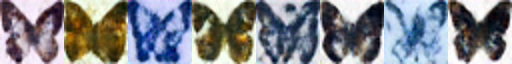

In [4]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

Diffusion model을 학습하는 것은 다음의 과정을 거친다는 것을 의미합니다:

1. 학습 데이터로부터 이미지들을 불러온다.
2. 각기 다른 양의 노이즈를 이미지들에 추가한다.
3. 노이즈가 추가된 이미지를 모델에 제시한다.
4. 모델이 노이즈를 얼마나 잘 제거하는지 (잘 유추하는지) 평가한다.
5. 이를 가지고 모델이 노이즈를 더욱 잘 제거하도록 모델을 업데이트한다.

이번에는 이 과정들을 하나씩 살펴보고 학습 루프를 구현해 봅시다.

## Step 2: Download a training dataset

이번 실습에서 우리는 Hugging Face Hub에 있는 이미지를 사용할 것입니다.

Hugging Face Hub의 다음 링크에서는 1000장의 나비 이미지 모음을 다운로드 받을 수 있습니다.

https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset

이는 생성 모델을 학습하기에는 매우 작은 모델이기는 하지만 간단한 실습을 하는 데에는 적당한 데이터셋이 될 수 있습니다.

더 좋은 품질의 이미지를 생성하기 위해서는 학습 데이터가 중요합니다!

In [5]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder to use your own data
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

학습 데이터에 있는 이미지 몇 장을 시각화 해봅시다:

X shape: torch.Size([8, 3, 32, 32])


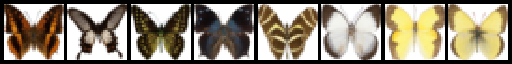

In [6]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

GPU 메모리가 넘치는 상황을 방지하고 학습 시간을 단축하기 위해 이번 실습에서는 32x32 이미지를 사용합니다.

## Step 3: Define the Scheduler

학습 과정에서 우리가 할 일은 이미지를 받아와서 노이즈를 추가하고 노이즈가 추가된 이미지를 모델에 제시하는 것입니다.

그리고 추론 과정에는 노이즈를 iterative하게 없애기 위해 모델을 사용하게 됩니다.

우리가 사용하는 `diffusers` 모듈에서는 이 과정들이 **scheduler**라는 루틴에 의해 관리됩니다.

**Scheduler**는 각기 다른 timestep에 노이즈가 얼마나 추가되는지를 결정합니다.

DDPM 논문의 수식을 바탕으로 간단한 이론을 살펴봅시다. ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)

In [7]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

DDPM 논문은 매 timestep마다 작은 양의 노이즈를 추가하는 corruption process를 모델링합니다.

어떤 timestep에 해당하는 $x_{t-1}$이 주어졌을 때, 우리는 약간 더 noisy한 버전인 $x_{t}$를 다음과 같이 모델링할 수 있습니다:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>

즉, $x_{t-1}$을 받아서 $\sqrt{1 - \beta_t}$만큼 scaling하고 $\beta_t$로 scaling 된 노이즈를 추가합니다.

이 $\beta$는 scheduling 알고리즘에 따라 매 timestep t에 대해 정의되며 해당 timestep에 노이즈를 얼마나 추가할지를 결정합니다.

그러면, $x_{500}$을 계산하기 위해 위 과정을 500번 거쳐서 노이즈를 추가해야 하나 싶기도 하겠지만 이는 그렇지 않습니다.

어떤 t에 대해 $x_0$에 노이즈를 추가하기 위한 식을 다음과 같이 더욱 간단하게 모델링 할 수 있습니다: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

위 식의 $\sqrt{\bar{\alpha}_t}$과 $\sqrt{(1 - \bar{\alpha}_t)}$을 t에 대한 그래프로 그려보면 해보면 각 timestep마다 원래 이미지와 노이즈가 어떤 비율로 섞여서 계산되는지 한 눈에 볼 수 있습니다.

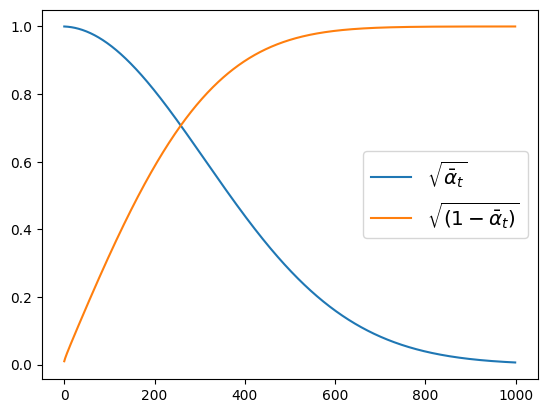

In [8]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

상술한 노이즈 추가 과정은 `diffusers` 모듈에서 **scheduler** 가 처리해 줍니다.

각 timestep마다 노이즈가 추가된 이미지가 어떤 형태로 생기는지 시각화 해봅시다.

Noisy X shape torch.Size([8, 3, 32, 32])


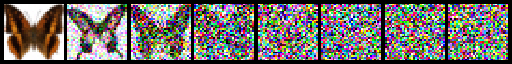

In [9]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

[이 비디오](https://www.youtube.com/watch?v=fbLgFrlTnGU)는 위의 수식을 설명하는 훌륭한 시각 자료입니다.

## Step 4: Define the Model

이제는 핵심 요소인 모델 그 자체를 정의해 봅시다.

대부분의 diffusion model들은 denoising을 수행하기 위해 [U-net](https://arxiv.org/abs/1505.04597) 구조의 변형을 사용합니다.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

해당 구조를 간단하게 설명하자면:
- 모델에 이미지를 제시하면 ResNet layer로 구성된 여러 개의 블록을 통과합니다. 이 블록들은 이미지의 해상도를 절반씩 줄입니다.
- 결과물의 해상도를 제시된 이미지의 해상도와 같게 만들기 위해 똑같은 블록을 통과하며 이미지의 해상도를 증가시킵니다.
- Skip connection이라는 것을 사용하여 downsample path와 upsample path를 연결합니다.

이 모델의 핵심은 제시된 이미지와 똑같은 크기를 같는 이미지를 추론해낸다는 것입니다.

이것은 이미지에 포함된 노이즈를 예측해야 하는 diffusion model에서 필요로 하는 요소입니다.

`Diffusers` 모듈은 이 구조를 PyTorch로 생성해주는 `UNet2DModel`이라는 클래스를 제공합니다.

`UNet2DModel` 클래스를 사용하여 노이즈를 예측하는 모델을 생성해 봅시다.

In [10]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

각 이미지를 모델에 제시했을 때 이미지의 크기와 결과물을 확인해 볼 수 있습니다.

보시는 바와 같이, 제시된 이미지와 똑같은 크기를 갖는 이미지를 결과물로 제시하는 것을 확인할 수 있습니다.

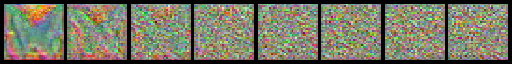

In [11]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape
show_images(model_prediction).resize((8 * 64, 64), resample=Image.NEAREST)

다음 스텝에서는 모델을 학습하는 과정을 살펴 봅시다.

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004. 

데이터가 준비됐고 모델도 정의됐으니 이제는 모델을 학습해 볼 시간입니다!

아래는 PyTorch로 구현된 일반적인 학습 루프입니다.

이 루프를 사용하여 배치마다 데이터를 제시하고 이를 가지고 loss를 계산하여 모델을 업데이트 해 나갑니다.

각 배치마다, 우리는 다음 작업들을 수행하게 됩니다:
- Timestep t를 랜덤하게 샘플링합니다.
- 샘플링한 timestep에 따라 이미지에 노이즈를 추가합니다.
- 노이즈가 추가된 이미지를 모델에 제시합니다.
- 모델이 예측한 결과를 타겟 (이 경우에서는 노이즈)과 비교하고 loss를 계산합니다.
- PyTorch의 optimization routine을 사용하여 모델의 파라미터를 업데이트 합니다.

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/home/piai/anaconda3/envs/cv_2025/lib/python3.8/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.14974792953580618
Epoch:10, loss: 0.11652904283255339


Loss를 시각화 해 보면 모델이 제대로 학습되고 있는 것을 알 수 있습니다.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

모델의 학습을 마쳤으니, 학습된 모델을 가지고 이미지를 생성해 보겠습니다.

### Option 1: Creating a pipeline:

In [ ]:
from diffusers import DDPMPipeline  # diffusers/src/diffusers/pipelines/ddpm/pipeline_ddpm.py

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
pipeline_output = image_pipe()
pipeline_output.images[0]

로컬 폴더에 생성한 파이프라인을 저장할 수도 있습니다:

In [ ]:
image_pipe.save_pretrained("my_pipeline")

### Option 2: Writing a Sampling Loop

`diffusers` 모듈이 제공하는 파이프라인 대신 직접 이미지를 생성하는 루틴을 구현할 수도 있습니다:

이미지 생성은 랜덤한 노이즈로부터 시작해서 timestep을 차근차근 통과하며 노이즈를 제거하는 과정으로 이루어집니다.
노이즈를 제거하는 각 과정에서 우리가 학습한 U-Net이 사용됩니다.

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=len(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)